# 실습 내용

- 다양한 알고리즘으로 모델을 만들고 성능을 예측합니다.
- 성능이 좋을 것으로 판단된 모델의 성능을 튜닝합니다.
- 튜닝된 모델의 성능을 평가합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
# 데이터 불러오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data['CHURN'] = data['CHURN'].map({'STAY':0, 'LEAVE': 1})

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [3]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- CHURN: 이탈(번호이동) 여부

In [4]:
# 기술통계 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,0.492600
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,0.499958
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,0.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,0.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,0.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,1.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000,1.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [6]:
# 제거 대상: id
drop_cols = ['id']

# 변수 제거
data.drop(drop_cols, axis=1, inplace = True)

# 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**2) x, y 분리**

In [7]:
# Target 설정
target = 'CHURN'
# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

**3) 가변수화**

In [9]:
# 가변수화 대상: REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN
dumm_cols = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
x = pd.get_dummies(x, columns=dumm_cols, drop_first=True, dtype=int)

# 확인
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,0,0,1,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0


**4) 학습용, 평가용 데이터 분리**

In [10]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

**5) 정규화**

In [11]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.fit_transform(x_test)


# 4.성능 예측

- 여러 알고리즘으로 모델을 만들고 K-Fold CV로 성능을 예측합니다.
- 하이퍼파라미터를 설정하지 않고 진행합니다.
- 각 모델의 성능 정보를 수집해 마지막에 비교합니다.

In [ ]:
# xgboost 설치
# !pip install xgboost

In [ ]:
# lightgbm 설치
# !pip install lightgbm

- 이후 사용할 함수를 모두 불러옵니다.

In [12]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

**1) KNN**

- KNN 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [39]:
# 선언하기
model = KNeighborsClassifier(n_neighbors=10)

In [40]:
# 성능예측
cv_score = cross_val_score(model, x_train_s, y_train, cv=10)

In [41]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.58071429 0.605      0.60928571 0.60571429 0.60857143 0.57714286
 0.62       0.61357143 0.61857143 0.61142857]
0.605


In [42]:
# 결과수집
result = {}
result['KNN'] = cv_score.mean()

**2) Decision Tree**

- Decision Tree 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [46]:
# 선언하기
model = DecisionTreeClassifier(max_depth=5, random_state=1)

In [47]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=10)

In [48]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.69857143 0.69142857 0.69857143 0.69285714 0.69428571 0.695
 0.70857143 0.69142857 0.70428571 0.70285714]
0.6977857142857143


In [49]:
# 결과수집
result['Decision Tree'] = cv_score.mean()

**3) Logistic Regression**

- Logistic Regression 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [50]:
# 선언하기
model = LogisticRegression()

In [51]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=10)

In [52]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.62642857 0.63       0.63142857 0.64285714 0.62571429 0.62571429
 0.64928571 0.63642857 0.65285714 0.62142857]
0.6342142857142857


In [53]:
# 결과수집
result['Logistic Regression'] = cv_score.mean()

**4) Random Forest**

- Random Forest 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [54]:
# 선언하기
model = RandomForestClassifier(max_depth=5, random_state=1)

In [55]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=10)

In [ ]:
# 결과확인
print(cv_score)
print(cv_score.mean())

In [ ]:
# 결과수집
result['Random Forest'] = cv_score.mean()

**5) XGBoost**

- XGBoost 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [56]:
# 선언하기
model = XGBClassifier(max_depth=5, random_state = 1)

In [59]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=10)

In [60]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.68571429 0.66571429 0.70428571 0.69071429 0.66857143 0.69071429
 0.69571429 0.67785714 0.70142857 0.68785714]
0.6868571428571428


In [58]:
# 결과수집
result['XGBoost'] = cv_score.mean()

**6) LightGBM**

- LightGBM 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [62]:
# 선언하기
model = LGBMClassifier(max_depth=5, random_state = 1, verbose = -1)

In [63]:
# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv=10)

In [65]:
# 결과확인
print(cv_score)
print(cv_score.mean())

[0.68571429 0.69       0.71642857 0.685      0.68       0.69142857
 0.70071429 0.685      0.705      0.70571429]
0.6944999999999999


In [66]:
# 결과수집
result['LightGBM'] = cv_score.mean()

# 5.결과 확인

- 예측된 각 모델의 성능을 비교합니다.

In [67]:
# 성능 비교
print('=' * 40)
for m_name, score in result.items():
    print(m_name, score.round(3))
print('=' * 40)

KNN 0.605
Decision Tree 0.698
Logistic Regression 0.634
XGBoost 0.696
LightGBM 0.694


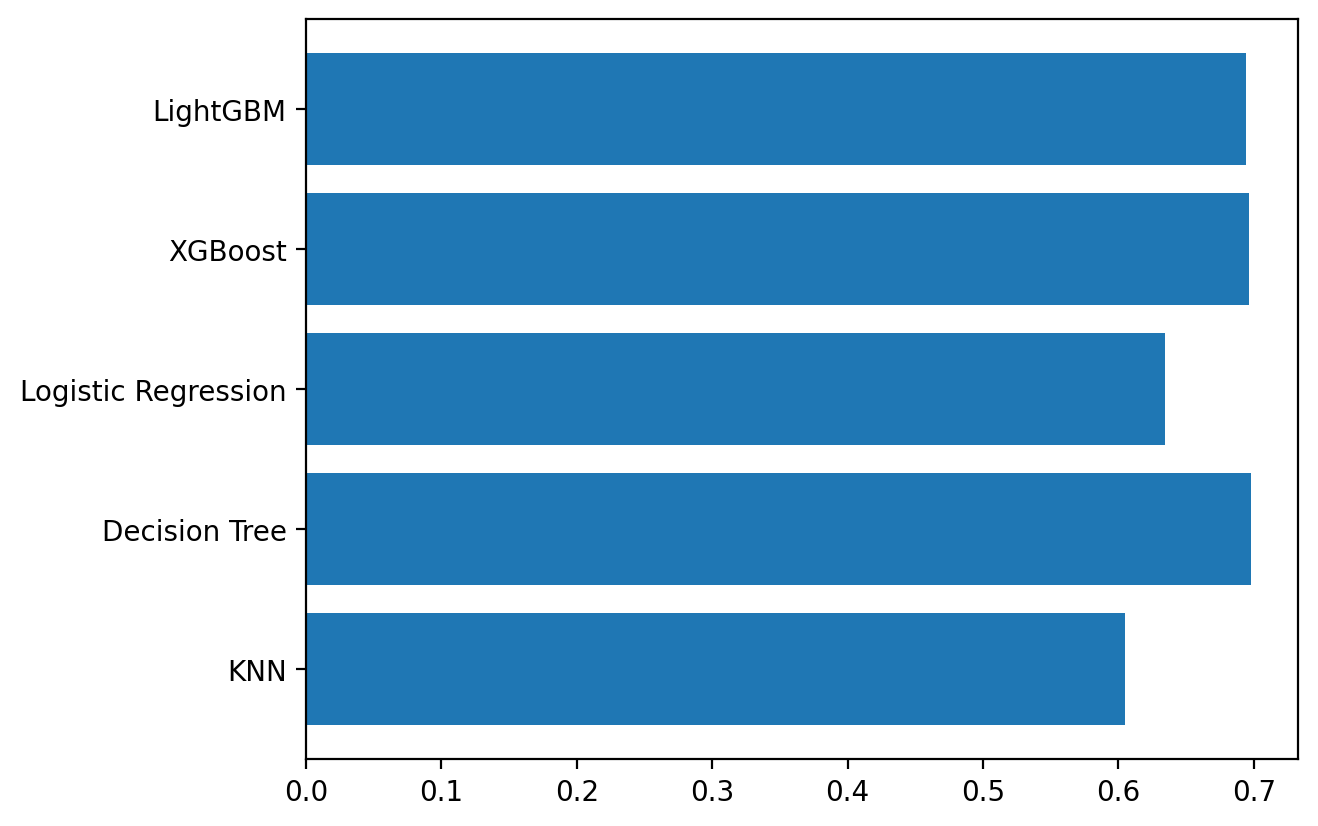

In [68]:
# 성능 시각화 비교
plt.barh(list(result.keys()), result.values())
plt.show()

# 6.성능 튜닝

- 위에서 성능이 가장 좋을 것으로 예측된 모델을 튜닝합니다.
- 본 실습에서는 LightGBM 모델 성능을 튜닝합니다.

In [69]:
# 기본 모델 선언
model_dt = LGBMClassifier(max_depth=5, random_state=1, verbose=-1)

# 파라미터 지정
  # max_depth: range(1, 21)
params = {'max_depth' : range(1, 21)}

# 모델 선언
model = GridSearchCV(model_dt,
                      params,
                      cv=5,
                    scoring='accuracy')

In [70]:
# 학습하기(많은 시간이 소요될 수 있음)
model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=5, random_state=1, verbose=-1),
             param_grid={'max_depth': range(1, 21)}, scoring='accuracy')

In [71]:
# 최적 파라미터, 예측 최고 성능
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

[0.67542857 0.69257143 0.69528571 0.6955     0.69585714 0.698
 0.69635714 0.69664286 0.69671429 0.69635714 0.69621429 0.69421429
 0.69528571 0.69392857 0.69642857 0.69785714 0.69621429 0.69621429
 0.69621429 0.69621429]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 6}
--------------------------------------------------------------------------------
최고성능: 0.6980000000000001


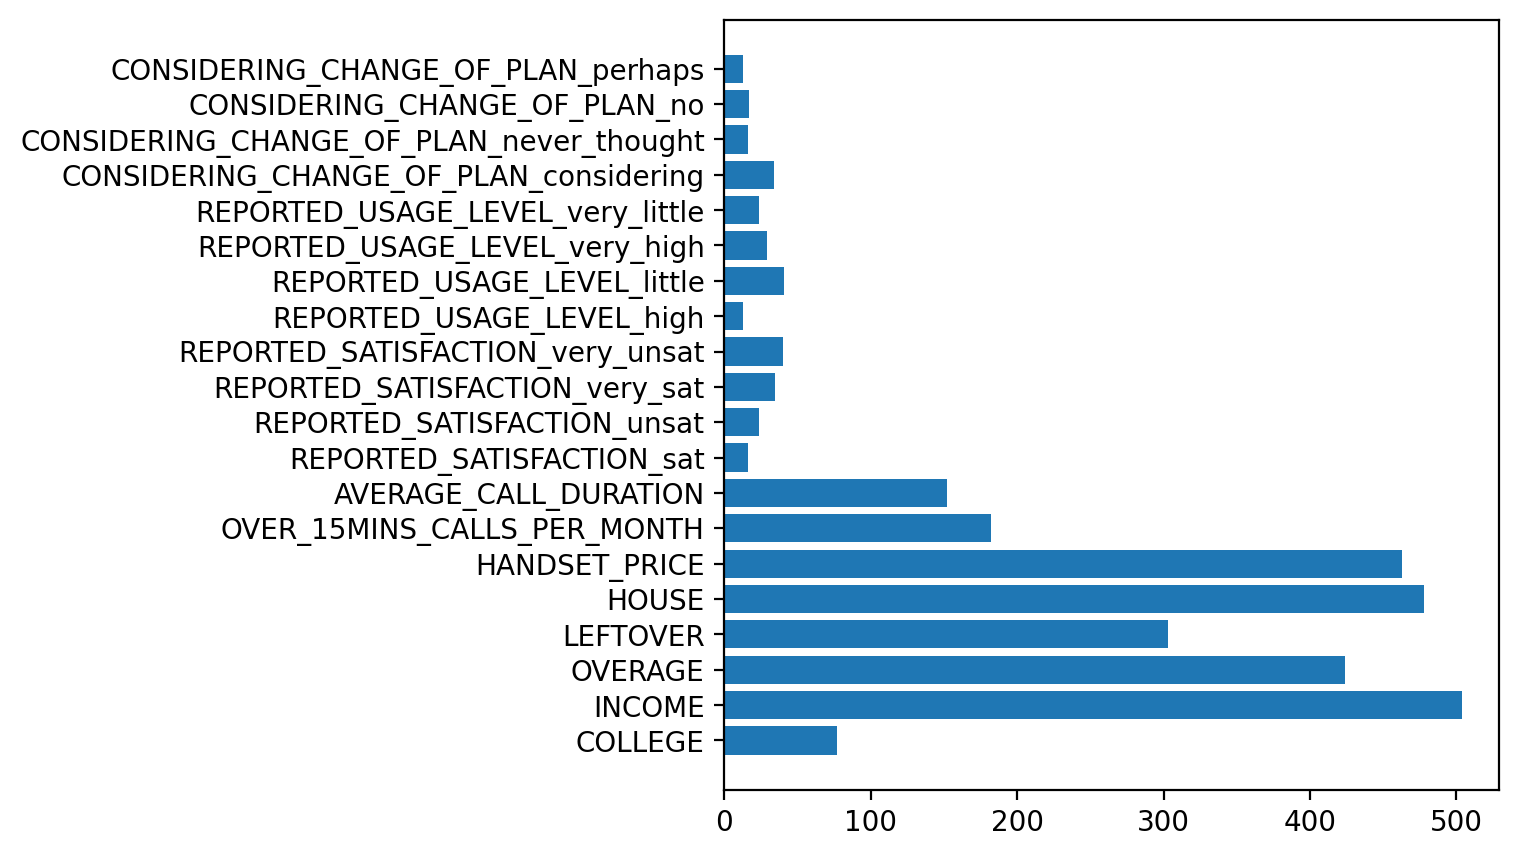

In [72]:
# 변수 중요도 시각화
plt.figure(figsize=(5, 5))
plt.barh(y=list(x), width=model.best_estimator_.feature_importances_)
plt.show()

# 7.성능 평가

- 최적 파라미터로 학습된 모델에 대해 최종 성능 평가를 진행합니다.

In [73]:
# 예측하기
y_pred = model.predict(x_test)

In [74]:
# 성능평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1953 1112]
 [ 747 2188]]
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      3065
           1       0.66      0.75      0.70      2935

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000

